In [1]:
import numpy as np
import cv2
from PIL import Image

In [109]:
def imshow(img: np.ndarray, scale=1.0):
    temp_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    temp_img = cv2.resize(temp_img, None, fx=scale, fy=scale)
    display(Image.fromarray(temp_img))

def draw_points(img: np.ndarray, points: np.ndarray):
    for x, y in points:
        img = cv2.circle(img, (x,y), radius=5, color=(0, 0, 255), thickness=-1)
    return img

def draw_mask(img: np.ndarray, mask: np.ndarray):
    if len(img.shape) == 3:
        color = (0, 0, 255)
    else:
        color = 255
    temp_img = img.copy()
    temp_img[mask > 0] = color
    return temp_img

## Loading videos/images 

In [131]:
# game = cv2.VideoCapture("./videos/asmr_chess_short.mp4")
# if game.isOpened():
#     print("Video loaded")

In [132]:
# game.set(cv2.CAP_PROP_POS_FRAMES, 150)
# ret, test_frame = game.read()
# test_frame_gray = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)
# imshow(test_frame)

In [121]:
board_img = cv2.imread("./images/stock_chessboard_empty.jpg")
# board_img = cv2.imread("./images/chess_with_pieces.jpg")
board_img_gray = cv2.cvtColor(board_img, cv2.COLOR_BGR2GRAY)

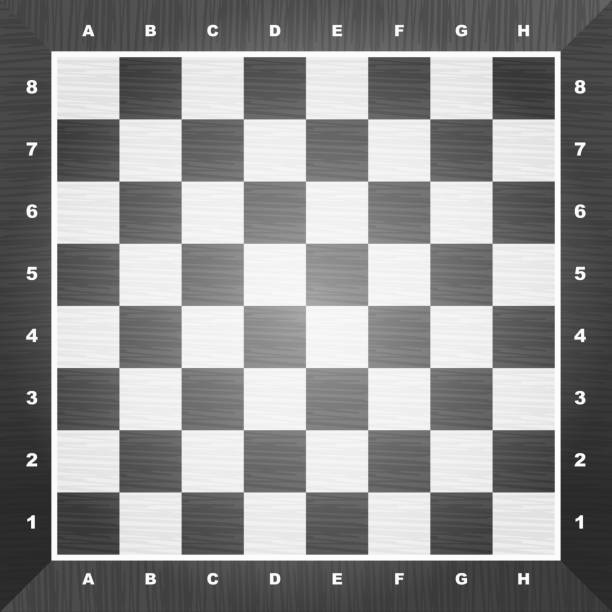

In [122]:
imshow(board_img_gray)

## Corner + Line detection

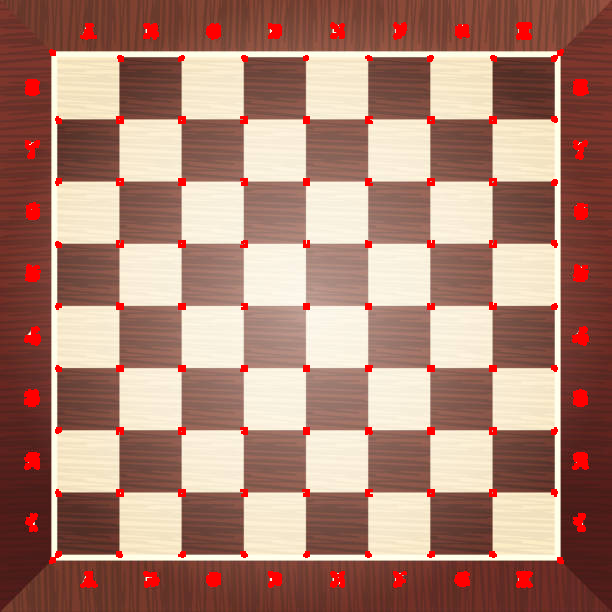

In [123]:
def sobel(src_image, kernel_size):
    grad_x = cv2.Sobel(src_image, cv2.CV_16S, 1, 0, ksize=kernel_size, scale=1,
                      delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(src_image, cv2.CV_16S, 0, 1, ksize=kernel_size, scale=1, 
                      delta=0, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    return grad


def calc_corners_mask(img_gray: np.ndarray):
    # img_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)
    img_gray = sobel(img_gray, 3)
    dst = cv2.cornerHarris(img_gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)

    corner_mask = np.zeros_like(img_gray, dtype=np.uint8)
    corner_mask[(dst > 0.01*dst.max())] = 255
    return corner_mask

temp_img = board_img.copy()
temp_img[calc_corners_mask(board_img_gray) > 0] = [0, 0, 255]
imshow(temp_img)

In [125]:
# def adaptive_thresh_gauss(img: np.ndarray, blocksize=3, constant=2):
#     img_ad_gauss = cv2.adaptiveThreshold(
#         img,
#         255,
#         cv2.ADAPTIVE_THRESH_MEAN_C,
#         cv2.THRESH_BINARY_INV,
#         blocksize,
#         constant,
#     )
#     return img_ad_gauss

def calc_lines_mask(img_gray: np.ndarray):
    otsu_thresh, _ = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(img_gray, 0.5*otsu_thresh, otsu_thresh, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, min(img_gray.shape) // 5)
    print(len(lines))

    # edges = adaptive_thresh_gauss(img_gray, 3)
    # lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    line_mask = np.zeros_like(img_gray, dtype=np.uint8)
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 10000 * (-b))
        y1 = int(y0 + 10000 * (a))
        x2 = int(x0 - 10000 * (-b))
        y2 = int(y0 - 10000 * (a))
        cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)
    return line_mask


def calc_lines_p_mask(img_gray: np.ndarray):
    otsu_thresh, _ = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(img_gray, 0.5*otsu_thresh, otsu_thresh, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
    
    line_mask = np.zeros_like(img_gray, dtype=np.uint8)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)
    return line_mask

def draw_lines(img: np.ndarray, lines: np.ndarray):
    line_image = np.copy(img)
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 10000 * (-b))
            y1 = int(y0 + 10000 * (a))
            x2 = int(x0 - 10000 * (-b))
            y2 = int(y0 - 10000 * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return line_image

22


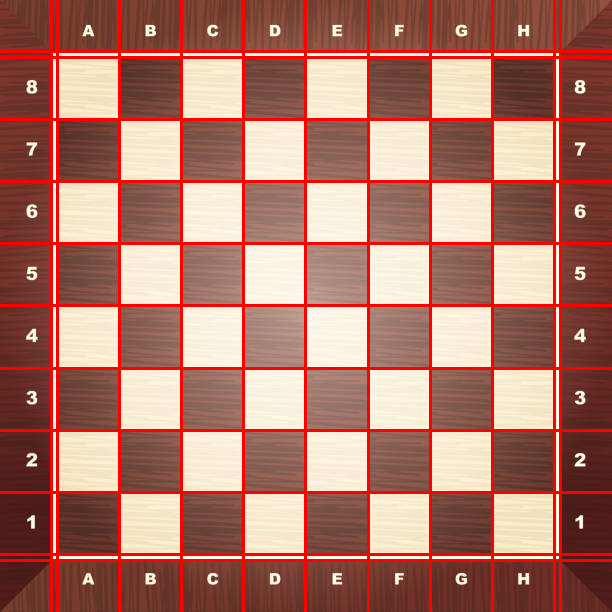

In [126]:
imshow(draw_mask(board_img, calc_lines_mask(board_img_gray)))

In [127]:
line_mask = calc_lines_p_mask(board_img_gray)
corner_mask = calc_corners_mask(board_img_gray)

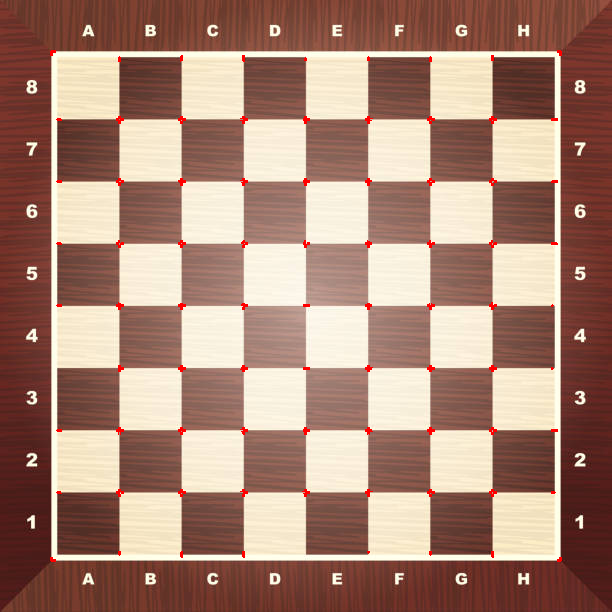

In [128]:
imshow(draw_mask(board_img, cv2.bitwise_and(line_mask, corner_mask)))

## cv2.findChessboardCorners() - [MAYBE ON TOP-DOWN EMPTY BOARD ONLY]

In [129]:
ret, corners = cv2.findChessboardCorners(
    board_img_gray, 
    (7, 7), 
    None, 
    flags=cv2.CALIB_CB_ADAPTIVE_THRESH+ cv2.CALIB_CB_EXHAUSTIVE
)
ret

True

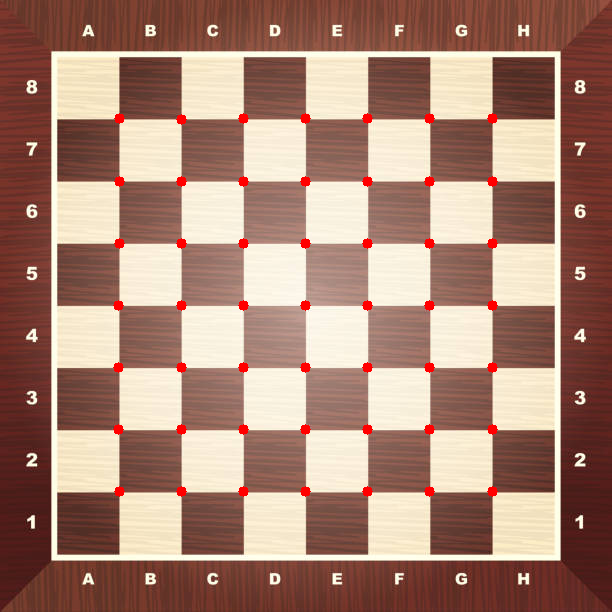

In [130]:
imshow(draw_points(board_img, corners[:, 0, :].astype(np.int32)))